# Use Essentia Library

### Load Audio

In [ ]:
!pip install essentia

In [182]:
from essentia.standard import *
from tempfile import TemporaryDirectory
import librosa


# Load audio file.
input_file_path="/content/drive/MyDrive/Colab Notebooks/data/per_drum/0_CC/08/CC_08_9955.m4a"
data, sr = librosa.load(input_file_path)
audio = MonoLoader(filename=input_file_path)()

# # librosa.effects.trim은 Librosa 라이브러리의 함수로, 오디오 신호에서 시작과 끝의 정적인 소음을 자르거나 제거하는 데 사용됩니다.
# audio = librosa.effects.trim(audio, top_db=5000, frame_length=1024, hop_length=512)[0]

<ipython-input-182-9be5a5415fc7>:8: UserWarning: PySoundFile failed. Trying audioread instead.
  data, sr = librosa.load(input_file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


In [173]:
audio, sr

(array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.7098977e-05,
        5.8075029e-06, 7.1974082e-06], dtype=float32),
 22050)

### Onset Detection

In [183]:
# 1. Compute the onset detection function (ODF).

# The OnsetDetection algorithm provides various ODFs.
od_hfc = OnsetDetection(method='hfc')
od_complex = OnsetDetection(method='complex')

# We need the auxilary algorithms to compute magnitude and phase.
w = Windowing(type='hann')
fft = FFT() # Outputs a complex FFT vector.
c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

# Compute both ODF frame by frame. Store results to a Pool.
pool = essentia.Pool()
for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
    magnitude, phase = c2p(fft(w(frame)))
    pool.add('odf.hfc', od_hfc(magnitude, phase))
    pool.add('odf.complex', od_complex(magnitude, phase))

# 2. Detect onset locations.
onsets = Onsets()

onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                    essentia.array([pool['odf.hfc']]),
                    # You need to specify weights, but if we use only one ODF
                    # it doesn't actually matter which weight to give it
                    [1])

onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])


# Add onset markers to the audio and save it to a file.
# We use beeps instead of white noise and stereo signal as it's more distinctive.

# We want to keep beeps in a separate audio channel.
# Add them to a silent audio and use the original audio as another channel. Mux both into a stereo signal.
# silence = [0.] * len(audio)

# beeps_hfc = AudioOnsetsMarker(onsets=onsets_hfc, type='beep')(silence)
# beeps_complex = AudioOnsetsMarker(onsets=onsets_complex, type='beep')(silence)

# audio_hfc = StereoMuxer()(audio, beeps_hfc)
# audio_complex = StereoMuxer()(audio, beeps_complex)

# # Write audio to files in a temporary directory.
# temp_dir = TemporaryDirectory()
# AudioWriter(filename=temp_dir.name + '/hiphop_onsets_hfc_stereo.mp3', format='mp3')(audio_hfc)
# AudioWriter(filename=temp_dir.name + '/hiphop_onsets_complex_stereo.mp3', format='mp3')(audio_complex)

### Show Graph

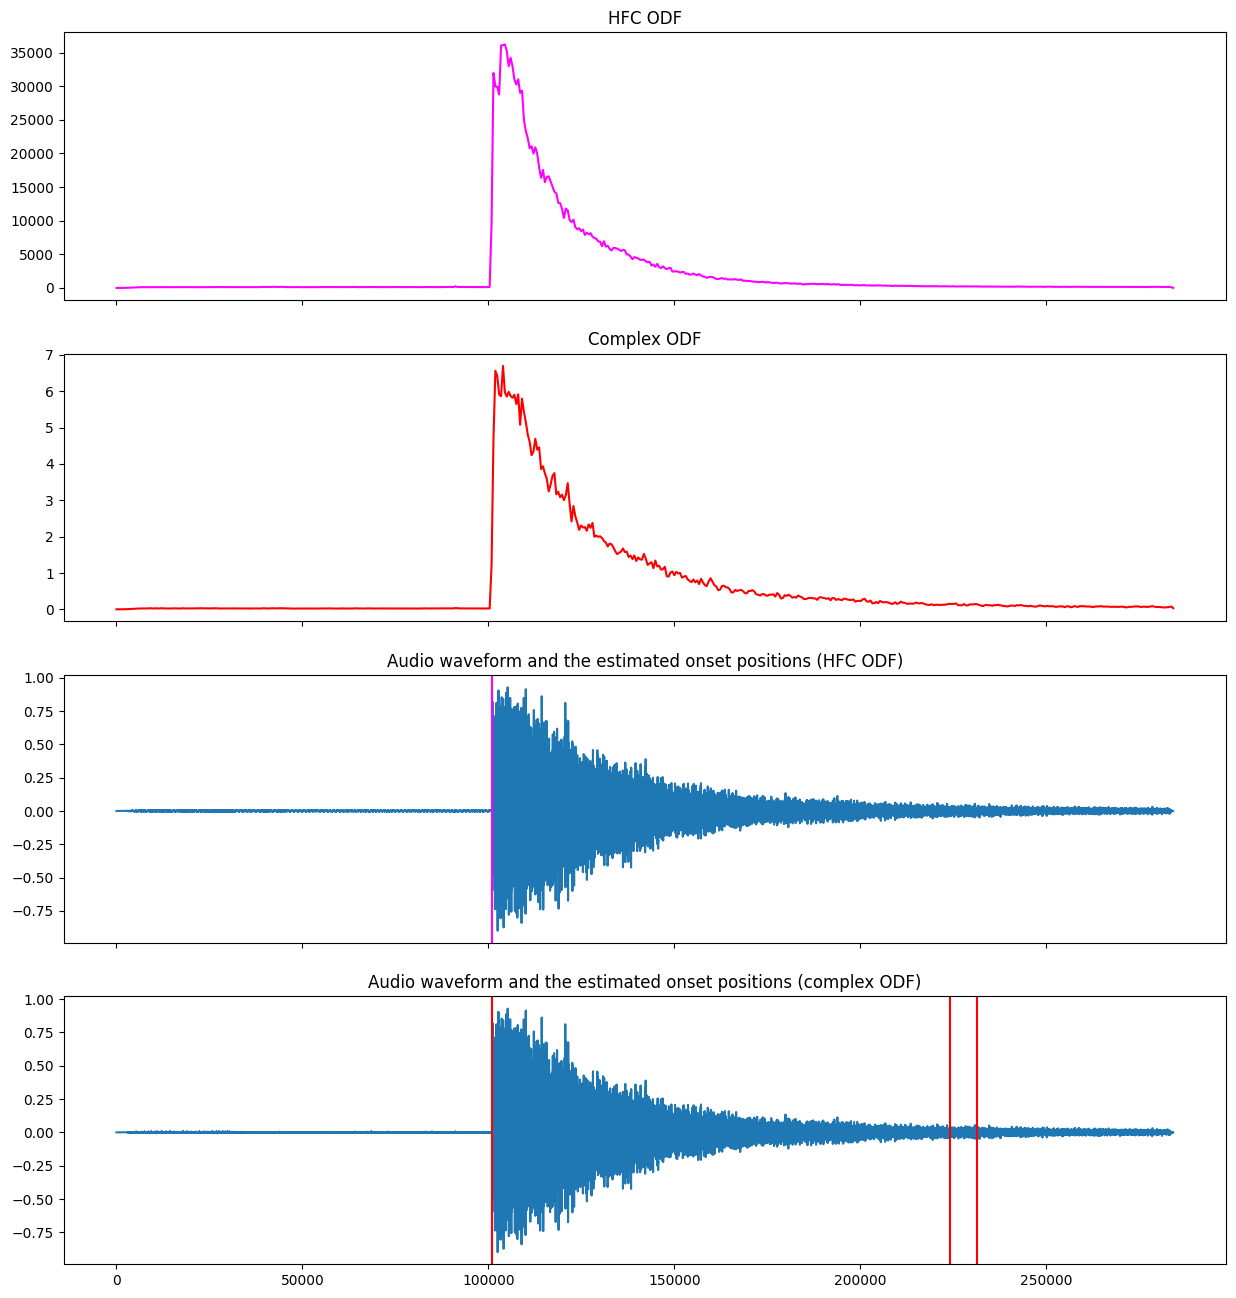

In [184]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy
n_frames = len(pool['odf.hfc'])
frames_position_samples = numpy.array(range(n_frames)) * 512

fig, ((ax1, ax2, ax3, ax4)) = plt.subplots(4, 1, sharex=True, sharey=False, figsize=(15, 16))

ax1.set_title('HFC ODF')
ax1.plot(frames_position_samples, pool['odf.hfc'], color='magenta')

ax2.set_title('Complex ODF')
ax2.plot(frames_position_samples, pool['odf.complex'], color='red')

ax3.set_title('Audio waveform and the estimated onset positions (HFC ODF)')
ax3.plot(audio)
for onset in onsets_hfc:
    ax3.axvline(x=onset*44100, color='magenta')

ax4.set_title('Audio waveform and the estimated onset positions (complex ODF)')
ax4.plot(audio)
for onset in onsets_complex:
    ax4.axvline(x=onset*44100, color='red')

### Separate Audio

In [10]:
# data separate
onsets_hfc[1]

2.6238549

In [ ]:
!pip install sox

In [27]:
ln = len(data)//2

In [ ]:
import librosa
import sox

start = (int)((onsets_hfc[0]-0.1) * sr)
end = (int)(onsets_hfc[1] * sr)

print(end)

duration = 0.1
new_end = (int)((onsets_hfc[0] + duration) * sr)
print(new_end)
end = min(end, new_end)

print(start)
print(end)

trimmed = data[start:end]

trimmed

# librosa.output.write_wav("/content/drive/MyDrive/Colab Notebooks/data/trimmed_data/examples.wav", trimmed, sr)

In [129]:
import scipy.io.wavfile
scipy.io.wavfile.write("/content/drive/MyDrive/Colab Notebooks/data/examples.wav", sr, trimmed)

In [130]:
from IPython.display import Audio, display

display(Audio("/content/drive/MyDrive/Colab Notebooks/data/examples.wav"))

# Use Librosa Library

In [ ]:
!pip install librosa

In [ ]:
!pip install numpy

In [ ]:
import librosa
import numpy as np

y, sr = librosa.load('/content/drive/MyDrive/Colab Notebooks/data/per_drum/1_HH/16/HH_16_0001.m4a')
onset_env = librosa.onset.onset_strength(y=y, sr=sr,
                                         aggregate=np.median,
                                         fmax=8000, n_mels=256)
peaks = librosa.util.peak_pick(onset_env, pre_max=3, post_max=3, pre_avg=3, post_avg=5, delta=0.5, wait=10)
peaks

In [ ]:
import matplotlib.pyplot as plt
times = librosa.times_like(onset_env, sr=sr, hop_length=512)
fig, ax = plt.subplots(nrows=2, sharex=True)
D = np.abs(librosa.stft(y))
librosa.display.specshow(librosa.amplitude_to_db(D, ref=np.max),
                         y_axis='log', x_axis='time', ax=ax[1])
ax[0].plot(times, onset_env, alpha=0.8, label='Onset strength')
ax[0].vlines(times[peaks], 0,
             onset_env.max(), color='r', alpha=0.8,
             label='Selected peaks')
ax[0].legend(frameon=True, framealpha=0.8)
ax[0].label_outer()

# Acustic Drum Data Load & Separate


In [ ]:
!pip install glob2

In [148]:
SR = 22050

In [149]:
ONSET_DURATION = 0.1

In [161]:
from essentia.standard import MonoLoader, OnsetDetection, Windowing, FFT, CartesianToPolar, FrameGenerator, Onsets, AudioOnsetsMarker, StereoMuxer, AudioWriter
from tempfile import TemporaryDirectory

# onset detection function
def onset_detect(input_path):
  # Load audio file.
  audio = MonoLoader(filename=input_path)()

  # 1. Compute the onset detection function (ODF).

  # The OnsetDetection algorithm provides various ODFs.
  od_hfc = OnsetDetection(method='hfc')
  od_complex = OnsetDetection(method='complex')

  # We need the auxilary algorithms to compute magnitude and phase.
  w = Windowing(type='hann')
  fft = FFT() # Outputs a complex FFT vector.
  c2p = CartesianToPolar() # Converts it into a pair of magnitude and phase vectors.

  # Compute both ODF frame by frame. Store results to a Pool.
  pool = essentia.Pool()
  for frame in FrameGenerator(audio, frameSize=1024, hopSize=512):
      magnitude, phase = c2p(fft(w(frame)))
      pool.add('odf.hfc', od_hfc(magnitude, phase))
      pool.add('odf.complex', od_complex(magnitude, phase))

  # 2. Detect onset locations.
  onsets = Onsets()

  onsets_hfc = onsets(# This algorithm expects a matrix, not a vector.
                      essentia.array([pool['odf.hfc']]),
                      # You need to specify weights, but if we use only one ODF
                      # it doesn't actually matter which weight to give it
                      [1])

  onsets_complex = onsets(essentia.array([pool['odf.complex']]), [1])

  # onset 개수가 짝수인 것을 우선
  if len(onsets_hfc) % 2 == 0:
    return onsets_hfc
  elif len(onsets_complex) % 2 == 0:
    return onsets_complex
  elif len(onsets_hfc) > len(onsets_complex):
    return onsets_hfc
  else:
    return onsets_complex

In [163]:
# trimmed audio
def audio_trim_per_onset(audio, onsets, sr=SR, duration=ONSET_DURATION):
  trimmed_audios = []
  for i in range(0, len(onsets)):
    start = (int)((onsets[i]) * sr)
    if i + 1 < len(onsets):
      end_by_onset = (int)(onsets[i + 1] * sr)
    end_by_duration = (int)((onsets[i] + duration) * sr)

    if i + 1 < len(onsets):
      end = min(end_by_onset, end_by_duration)
    else:
      end = end_by_duration

    trimmed = audio[start:end]
    trimmed_audios.append(trimmed)

  return trimmed_audios


In [164]:
import scipy.io.wavfile

# trimmed audio -> wav file write
def write_trimmed_audio(root_path, name, trimmed_audios):
  start = 1
  for audio in trimmed_audios:
    # exist or not
    if not os.path.exists(root_path):
      # if the demo_folder directory is not present
      # then create it.
      os.makedirs(root_path)
    scipy.io.wavfile.write(f'{root_path}/{name}_{start:04}.wav', sr, audio)
    start += 1

### for test

In [159]:
# trimming audio
trimmed_audios = audio_trim_per_onset(data, onsets_hfc, sr)
# print(trimmed_audios)

# new_file write
trim_root_path = '/content/drive/MyDrive/test'
name = 'example'
write_trimmed_audio(trim_root_path, name, trimmed_audios)

In [160]:
from IPython.display import Audio, display

wavs = os.listdir(trim_root_path)
for w in wavs:
  display(Audio(f'{trim_root_path}/{w}'))

### real

In [165]:
import os
import librosa

# load audio & trimmed per onset
# [pattern, per_drum]
# per_drum: [1_HH, 2_RC, ...], pattern: [P1, P2, ...]
# 04, 08, 16
def main(root_path, trim_path):
  datas = os.listdir(root_path)

  check = False
  for d in datas:
    if d.endswith('.m4a'):
      check = True
      wav = os.path.join(root_path, d)
      print(wav)

      # detect onsets
      onsets = onset_detect(wav)
      # print(onsets)

      # trimming audio
      audio, sr = librosa.load(wav, sr=SR)
      trimmed_audios = audio_trim_per_onset(audio, onsets, sr)
      # print(trimmed_audios)

      # new_file write
      name = d[:-4]
      write_trimmed_audio(trim_path, name, trimmed_audios)
    elif d.endswith('.txt') == False:
      new_root_path = os.path.join(root_path, d)
      new_trim_path = os.path.join(trim_path, d)
      main(new_root_path, new_trim_path)

In [ ]:
# 드럼 녹음 data path
input_file_path = "/per_drum/0_CC/04"
root_path = "/content/drive/MyDrive/Colab Notebooks/data" + input_file_path
trim_path = "/content/drive/MyDrive/Colab Notebooks/trimmed_data" + input_file_path
main(root_path, trim_path)

### Trash

In [144]:
import os
import librosa

# load audio & trimmed per onset
def main_backup(root_path, trim_path):
  drum_folders = os.listdir(root_path)
  # [pattern, per_drum]
  for drum_folder in drum_folders:
    drum_folder_path = os.path.join(root_path, drum_folder)
    try:
      element_folder = os.listdir(drum_folder_path)
      # per_drum: [1_HH, 2_RC, ...], pattern: [P1, P2, ...]
      for element in element_folder:
        element_folder_path = os.path.join(drum_folder_path, element)
        rhythm_folder = os.listdir(element_folder_path)
        # 04, 08, 16
        for rhythm in rhythm_folder:
          rhythm_folder_path = os.path.join(element_folder_path, rhythm)
          files = os.listdir(rhythm_folder_path)
          wav_files = [os.path.join(rhythm_folder_path, file) for file in files if file.endswith('.m4a')]
          for wav in wav_files:
            # print(wav)
            # detect onsets
            onsets = onset_detect(wav)
            # print(onsets)

            # trimming audio
            audio, sr = librosa.load(wav, sr=SR)
            trimmed_audios = audio_trim_per_onset(audio, onsets, sr)
            # print(trimmed_audios)

            # new_file write
            trim_root_path = os.path.join(trim_path, drum_folder, element, rhythm)
            name = os.path.basename(wav).split('/')[-1][:-4]
            write_trimmed_audio(trim_root_path, name, trimmed_audios)

    except Exception as e:
      print(e)